# State Estimation in a State-space Model (Forward Only)

In this demo, the goal is to filter noisy observations by performing on-line inference with a state-space model (SSM).

We denote by `x_t` the current state of the system (at time step `t`), by `x_t_min` the previous state at time `t-1`, `u` is a constant system input and `y_t` is a noisy observation of `x_t`:

\begin{align*}
    u &= 1\\
    n_t &\sim \mathcal{N}(0, v)\\
    x_t &= x_{t-1} + u\\
    y_t &= x_t + n_t
\end{align*}

We further assume that the observations are corrupted by i.i.d. Gaussian noise with variance `v`. 

The SSM can be represented by the following Forney-style factor graph, where the pictured section is chained over time:

```
                 (u)
                  |
    (x_t_min) --> + --> = --> (x_t)
                        |    
               (n_t)--> +
                        |
                      (y_t)
```

For on-line (forward-only) estimation in ForneyLab, it suffices to build a single-time-step section of the model. We then iteratively infer the posterior statistics by considering one observation at a time. After each inference step, we pass the posterior statistics on as the new prior statistics, leading to an (exact) on-line filtering algorithm that is equivalent to Kalman filtering.

We start by generating some data, and then showcase the ForneyLab functionality by walking through the model specification, algorithm generation and execution steps.

In [1]:
# Data
n_samples = 100
x = [t for t=1:n_samples] # True state
y = x + sqrt(200.0)*randn(n_samples); # Noisy observations of state

# Build the Model

In the model specification phase we define (one time-section of) the generative model. The syntax for defining the model mimics the mathematical notation of the model. Observed values are declared through `constant()`, and latent variables through the `Variable()` constructor.

Furthermore, ForneyLab allows for a distributed-as notation `~`, which declares a probabilistic relation between variables. Also the `+` and `*` operators accept variables as arguments, and impose an addition/multiplication constraint on their arguments.

The `placeholder()` function signals that its argument variable will be clamped to observations before the inference procedure.

In [2]:
using ForneyLab

g = FactorGraph()

# Noise variance
v = constant(200.0, id=:v) # variance of the observation noise

# Prior statistics
m_x_t_min = Variable(id=:m_x_t_min)
v_x_t_min = Variable(id=:v_x_t_min)

# State prior
@RV x_t_min ~ GaussianMeanVariance(m_x_t_min, v_x_t_min)

# Transition and observation model
u   = constant(1.0)
@RV n_t ~ GaussianMeanVariance(constant(0.0), v) # zero-mean gaussian observation noise
x_t = x_t_min + u
y_t = x_t + n_t

# Placeholders for prior statistics
placeholder(m_x_t_min, :m_x_t_min)
placeholder(v_x_t_min, :v_x_t_min)

# Observation placeholder
placeholder(y_t, :y_t)

# Name variable for ease of lookup
x_t.id = :x_t;

ForneyLab offers a `draw()` function that visualizes the factor graph.

In [3]:
ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 1505767949164677559 -->
 1505767949164677559 
 
 + 
 addition_1 
 
<!-- 10376035417176198365 -->
 10376035417176198365 
 
 clamp_1 
 
<!-- 1505767949164677559--10376035417176198365 -->
 1505767949164677559--10376035417176198365 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 7234385218733313866 -->
 7234385218733313866 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 1505767949164677559--7234385218733313866 -->
 1505767949164677559--7234385218733313866 
 
 x_t_min 
 1 out 
 2 in1 
 
<!-- 14370684318693023186 -->
 14370684318693023186 
 
 placeholder_v_x_t_min 
 
<!-- 14370684318693023186--7234385218733313866 -->
 14370684318693023186--7234385218733313866 
 
 v_x_t_min 
 3 v 
 1 out 
 
<!-- 6122854373383262282 -->
 6122854373383262282 
 
 v 
 
<!-- 2947282284954044172 -->
 2947282284954044172 
 
 placeholder_m_x_t_min 
 
<!-- 2947282284954044172--7234385218733313866 -->
 2947282284954044172--7234385218733313866 
 
 m_x_t_min 
 2 m 
 1 out 
 
<!-- 8592100164183898787 -->
 8592100164183898787 
 
 + 
 addition_2 
 
<!-- 8592100164183898787--1505767949164677559 -->
 8592100164183898787--1505767949164677559 
 
 x_t 
 1 out 
 2 in1 
 
<!-- 12448000145082790363 -->
 12448000145082790363 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 8592100164183898787--12448000145082790363 -->
 8592100164183898787--12448000145082790363 
 
 n_t 
 1 out 
 3 in2 
 
<!-- 342526402096757591 -->
 342526402096757591 
 
 clamp_2 
 
<!-- 10218534630495785578 -->
 10218534630495785578 
 
 placeholder_variable_2 
 
<!-- 10218534630495785578--8592100164183898787 -->
 10218534630495785578--8592100164183898787 
 
 variable_2 
 1 out 
 1 out 
 
<!-- 12448000145082790363--6122854373383262282 -->
 12448000145082790363--6122854373383262282 
 
 v 
 1 out 
 3 v 
 
<!-- 12448000145082790363--342526402096757591 -->
 12448000145082790363--342526402096757591 
 
 clamp_2 
 1 out 
 2 m

# Algorithm generation

Now that the factor graph is defined, we can generate a message passing algorithm (MPA) that computes the current state posterior from the  state prior and the current observation. The `sumProductAlgorithm()` function accepts the variables over which the posterior (marginals) are computed and performs two operations:
1. First, it generates a sum-product message-passing schedule (through `sumProductSchedule()`), which is simply an array of message-computation rules that computes the messages for the posterior. 
2. Secondly, it compiles this schedule to Julia code (through `messagePassingAlgorithm()`).

As a side note, the `draw()` function accepts a `schedule` argument. The result of `sumProductSchedule()` may be assigned to this argument, and plots the generated schedule with the factor graph. This functionality could be useful when debugging message passing schedules.

In [4]:
algo = sumProductAlgorithm(x_t) # Figure out a schedule and compile to Julia code

println(algo)

function step!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(4))

messages[1] = ruleSPGaussianMeanVarianceOutVPP(nothing, Message(Univariate, PointMass, m=data[:m_x_t_min]), Message(Univariate, PointMass, m=data[:v_x_t_min]))
messages[2] = ruleSPAdditionOutVGP(nothing, messages[1], Message(Univariate, PointMass, m=1.0))
messages[3] = ruleSPGaussianMeanVarianceOutVPP(nothing, Message(Univariate, PointMass, m=0.0), Message(Univariate, PointMass, m=200.0))
messages[4] = ruleSPAdditionIn1PVG(Message(Univariate, PointMass, m=data[:y_t]), nothing, messages[3])

marginals[:x_t] = messages[2].dist * messages[4].dist

return marginals

end


# Execution

The resulting message algorithm is a string containing Julia code, stored in `algo` (see the output of the previous cell). In the next cell, we evaluate this code so we can actually execute the generated `step!` function, by `eval(parse(algo))`. The `step!` function executes one time step of the inference process. It takes a dictionary with placeholder values (`data`) as input and outputs an array `marginals` that hold the inference results. 

In [5]:
# Define algorithm
eval(parse(algo))

# Define values for prior statistics
m_x_0 = 0.0
v_x_0 = 1000.0

m_x = Vector{Float64}(n_samples)
v_x = Vector{Float64}(n_samples)

m_x_t_min = m_x_0
v_x_t_min = v_x_0
for t = 1:n_samples
    # Prepare data and prior statistics
    data = Dict(:y_t       => y[t],
                :m_x_t_min => m_x_t_min,
                :v_x_t_min => v_x_t_min)
    
    # Execute algorithm
    marginals = step!(data)

    # Extract posterior statistics
    m_x[t] = mean(marginals[:x_t])
    v_x[t] = var(marginals[:x_t])
    
    # Prepare statistics for next step
    m_x_t_min = m_x[t]
    v_x_t_min = v_x[t]
end

# Results

That's it. We can now plot the filter output (mean and standard deviation of the state posterior) together with the noisy observations over time.

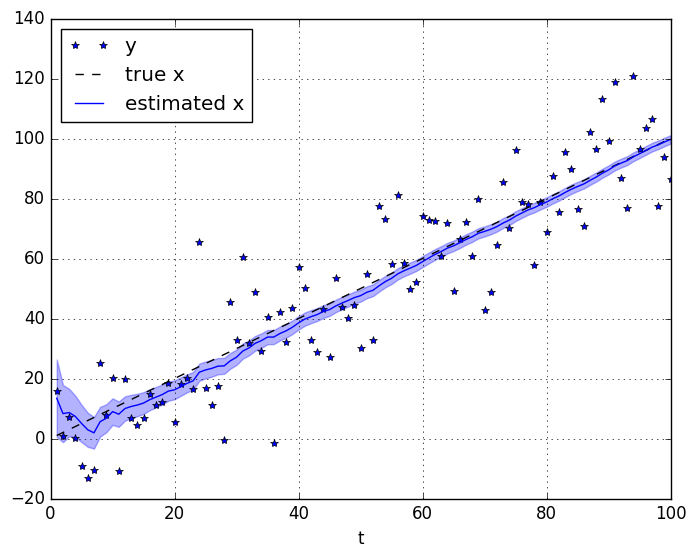

In [6]:
using PyPlot

plot(collect(1:n_samples), y, "b*", label="y")
plot(collect(1:n_samples), x, "k--", label="true x")
plot(collect(1:n_samples), m_x, "b-", label="estimated x")
fill_between(collect(1:n_samples), m_x-sqrt.(v_x), m_x+sqrt.(v_x), color="b", alpha=0.3);
grid("on")
xlabel("t")
legend(loc="upper left");